In [79]:
import pandas as pd
import math as mt
import re
import numpy as np
import matplotlib.pyplot as plt

## auxillary functions

In [80]:
def get_claims(df: pd.DataFrame, id: int) -> pd.DataFrame:
    claims_text = df.loc[(df['Publn_Nr'] == id) & (df['Type'].str.match('Claim')), 'Text']  # get claim text
    return claims_text

In [81]:
def concantenate_claims(claims: pd.Series) -> str:
    return ' '.join(claims)

## apply NLP

pre: patents sorted from earliest to latest patent

In [82]:
names = ["FW", "LC", "LIB",  "SC", "SPV", "Wind"]  # technology file names
n = "LIB"  # other tech

In [83]:
df = pd.read_excel(f'sorted_data/DB_{n}_USPTO_sorted.xlsx')
df['Publn_Nr'] = df['Publn_Nr'].astype(int)

In [84]:
# test, delete me
id = 10563637
claims_text = get_claims(df, id)
' '.join(claims_text)

''

In [85]:
def checkRoman(token):
    re_pattern = '[mdcxvi]+[a-z]'
    if re.fullmatch(re_pattern, token):
        return True
    return False

In [86]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import operator
import re

In [87]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
patent_claims = []  # list to store all patents claims for technology for year
list_replace = []
stwrds = stopwords.words('english')
stemmer = SnowballStemmer('english')


In [89]:
def get_tokens(text: str) -> tuple[list, dict]:
    # Standardize greek letters and eliminate symbols
    line = text.strip().lower()
    # Standardize greek letters and eliminate symbols
    for r in list_replace:
        line = line.replace(*r)
    # Replace .sub. and .sup. in each patent
    line = line.replace('.sub.', '')
    line = line.replace('.sup.', '')
    # Extract tokens using a regular expression
    tokens = re.findall('[a-z0-9][a-z0-9-]*[a-z0-9]+|[a-z0-9]', line)
    tokens = set(tokens)
    # Remove stopwords, and words of only one char and compossed only
    # of numbers
    tokens = [token for token in tokens if len(token) > 1 and
                token not in stwrds and
                not token.replace('-', '').isnumeric()]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = set(tokens)
    tokens = list(tokens)
    tokens.sort()
    tokens = [token for token in tokens if len(token) > 1 and
                token not in stwrds and
                not checkRoman(token)]
    count = {}
    # count occurances of each token
    for token in tokens:
        count[token] = text.count(token)
    # sort tokens by frequency
    tokens = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    return tokens, count

In [90]:
def update_total_counts(counts_total: dict, counts: dict) -> dict:
    for token, count in counts.items():
        if token in counts_total:
            counts_total[token] += count
        else:
            counts_total[token] = count
    return counts_total

In [91]:
def get_entropy(counts: dict) -> float:
    """
    Calculate the entropy of a dictionary of token counts
    """
    entropy = 0
    total = sum(counts.values())
    for token, count in counts.items():
        if count > 0:
            p = count / total
            entropy = p * mt.log2(1/p)
    return entropy

In [ ]:
# get claims ordered by publication date
entropies = []   # conditional entropies for each patent, sorted by publication date
counts_total = {}

for pub_nr in df['Publn_Nr'].unique():
    claims = get_claims(df, pub_nr)
    if claims.empty:
        entropies.append(np.nan)  # add NA if no claims in data set
        continue    # skip if no claims in data set
    text = concantenate_claims(claims)  # concantenate claims
    tokens, count = get_tokens(text)    # get tokens and counts of words
    counts_total = update_total_counts(counts_total, count)   # update total counts for conditional entropy
    # get conditional entropy fixme
    cond_entropy = get_entropy(counts_total) # - get_entropy(count)

    # get single entropy
    # cond_entropy = get_entropy(count)
    entropies.append(cond_entropy)

In [ ]:
df_unique = df.drop_duplicates(subset=['Publn_Nr'])[['Publn_Nr', 'Publn_Date']]
df_unique['Entropy'] = entropies

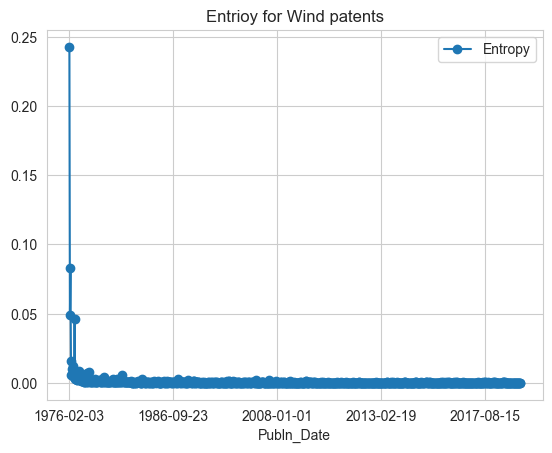

In [ ]:
df_unique.plot(x='Publn_Date', y='Entropy', kind='line', marker='o', title=f'Entrioy for {n} patents')
plt.show()

Text(0.5, 1.0, 'Conditional Entropy of Patent Claims')

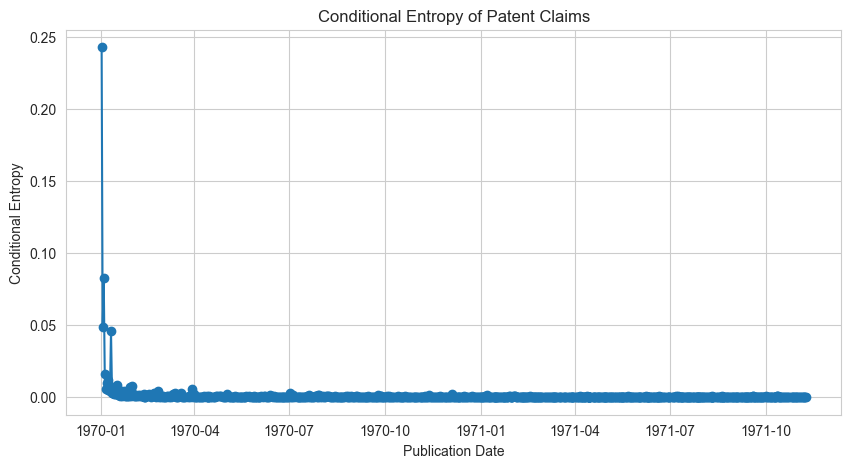

In [ ]:
# plot entropy trend
import matplotlib.dates as mdates

import seaborn as sns
sns.set_style("whitegrid")  # Better visual style


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_unique['Publn_Date'], df_unique['Entropy'], marker='o', linestyle='-')

# # Format x-axis
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically space dates
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

# pub_dates = df_unique['Publn_Date'].values

# plt.plot(pub_dates, entropies)
plt.xlabel('Publication Date')
plt.ylabel('Conditional Entropy')
plt.title('Conditional Entropy of Patent Claims')